In [1]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from torchvision import transforms
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_dir = Path("/kaggle/input/restore-image/train/train")
real_dir = train_dir / "real_images"
filtered_dir = train_dir / "filtered_images"

Data Augmentation

In [3]:
base_path = Path("/kaggle/working/dataset")
real_path = base_path / "real"
filtered_path = base_path / "filtered"

In [4]:
real_path.mkdir(parents=True, exist_ok=True)
filtered_path.mkdir(parents=True, exist_ok=True)

In [5]:
filters = [[0, 1, 1, 2], [0, 2, 2, 1], [1, 0, 0, 2],
           [1, 2, 2, 0], [2, 0, 0, 1], [2, 1, 1, 0],
           [1, 0, 2, 1], [2, 0, 1, 2], [0, 1, 2, 0],
           [2, 1, 0, 2], [0, 2, 1, 0], [1, 2, 0, 1]]

def apply_filter(img, pattern):
    """Applies a 2x2 filter pattern using efficient NumPy slicing."""
    # Create a new image with the correct shape and data type (uint8)
    filtered_img = np.zeros_like(img)
    
    # Apply the pattern to the entire grid at once using slicing
    # Top-left pixels
    filtered_img[0::2, 0::2, pattern[0]] = img[0::2, 0::2, pattern[0]]
    # Top-right pixels
    filtered_img[0::2, 1::2, pattern[1]] = img[0::2, 1::2, pattern[1]]
    # Bottom-left pixels
    filtered_img[1::2, 0::2, pattern[2]] = img[1::2, 0::2, pattern[2]]
    # Bottom-right pixels
    filtered_img[1::2, 1::2, pattern[3]] = img[1::2, 1::2, pattern[3]]
    
    return filtered_img

In [6]:
image_files = real_dir.glob("*.png")

data_id = 0
for file_path in (image_files):
    image = cv2.imread(str(file_path))

    filtered_iamges = []
    for f in filters:
        filtered_image = apply_filter(image, f)

        filtered_image_path = Path(f"/kaggle/working/dataset/filtered/{data_id}.png")
        real_image_path = Path(f"/kaggle/working/dataset/real/{data_id}.png")
        cv2.imwrite(str(filtered_image_path), filtered_image)
        cv2.imwrite(str(real_image_path), image)
        data_id += 1
        

In [7]:
all_filenames = os.listdir("/kaggle/working/dataset/real")
all_filenames.sort()  # Optional: to ensure matching order

train_filenames, val_filenames = train_test_split(
    all_filenames, test_size=0.2, random_state=42
)

In [8]:
class ImageDataset(Dataset):
    def __init__(self, original_dir, filtered_dir, filenames,transform=None):
        self.original_dir = original_dir
        self.filtered_dir = filtered_dir
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.filenames)
    

    def __getitem__(self, idx):
        original_path = os.path.join(self.original_dir, self.filenames[idx])
        filtered_path = os.path.join(self.filtered_dir, self.filenames[idx])

        original_img = Image.open(original_path).convert('RGB')
        filtered_img = Image.open(filtered_path).convert('RGB')

        if self.transform:
            original_img = self.transform(original_img)
            filtered_img = self.transform(filtered_img)

        return original_img, filtered_img

In [9]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = ImageDataset(real_path, filtered_path, train_filenames, transform=transform)
val_dataset = ImageDataset(real_path, filtered_path, val_filenames, transform=transform)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,  
    num_workers=2,
    pin_memory=True
)

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
        )

        #Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [11]:
class UNetMini(nn.Module):
    def __init__(self):
        super(UNetMini, self).__init__()

        # Encoder
        self.down1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.upconv1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Final layer
        self.final = nn.Conv2d(64, 3, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.pool1(x1)

        x3 = self.down2(x2)
        x4 = self.pool2(x3)

        x5 = self.bottleneck(x4)

        x6 = self.up2(x5)
        x6 = torch.cat([x6, x3], dim=1)
        x7 = self.upconv2(x6)

        x8 = self.up1(x7)
        x8 = torch.cat([x8, x1], dim=1)
        x9 = self.upconv1(x8)

        out = self.final(x9)
        return self.activation(out)

In [12]:
def masked_mse_loss(pred, target, mask):
    diff = (pred - target) ** 2
    masked_diff = diff * mask
    return masked_diff.sum() / mask.sum().clamp(min=1)

In [13]:
model = UNetMini().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
train_losses = []

In [21]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for original_img, filtered_img in train_dataloader:
        filtered_img = filtered_img.to(device)
        original_img = original_img.to(device)

        # Generate or load mask
        mask = (original_img != 0).float().to(device)

        optimizer.zero_grad()
        output = model(filtered_img)

        loss = masked_mse_loss(output, original_img, mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for original_img, filtered_img in val_dataloader:
            filtered_img = filtered_img.to(device)
            original_img = original_img.to(device)

            mask = (original_img != 0).float().to(device)

            output = model(filtered_img)
            val_loss += masked_mse_loss(output, original_img, mask).item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_dataloader):.6f}, Val Loss: {val_loss/len(val_dataloader):.6f}")


Epoch 1/20, Train Loss: 0.001357, Val Loss: 0.001371
Epoch 2/20, Train Loss: 0.001343, Val Loss: 0.001382
Epoch 3/20, Train Loss: 0.001335, Val Loss: 0.001393
Epoch 4/20, Train Loss: 0.001324, Val Loss: 0.001339
Epoch 5/20, Train Loss: 0.001316, Val Loss: 0.001344
Epoch 6/20, Train Loss: 0.001307, Val Loss: 0.001326
Epoch 7/20, Train Loss: 0.001299, Val Loss: 0.001333
Epoch 8/20, Train Loss: 0.001291, Val Loss: 0.001345
Epoch 9/20, Train Loss: 0.001283, Val Loss: 0.001320
Epoch 10/20, Train Loss: 0.001275, Val Loss: 0.001361
Epoch 12/20, Train Loss: 0.001263, Val Loss: 0.001358
Epoch 13/20, Train Loss: 0.001258, Val Loss: 0.001336
Epoch 14/20, Train Loss: 0.001248, Val Loss: 0.001321
Epoch 15/20, Train Loss: 0.001246, Val Loss: 0.001319
Epoch 16/20, Train Loss: 0.001242, Val Loss: 0.001313
Epoch 18/20, Train Loss: 0.001231, Val Loss: 0.001285
Epoch 19/20, Train Loss: 0.001225, Val Loss: 0.001276
Epoch 20/20, Train Loss: 0.001222, Val Loss: 0.001279


In [16]:
test_dir = Path("/kaggle/input/restore-image/test/test/filtered_images")
test_files = test_dir.glob("*.png")

In [17]:
preprocess = transforms.Compose([
    transforms.ToTensor(),  # Converts HWC (uint8) → CHW (float32) in [0, 1]
])

In [ ]:
submission_rows = []

for file_path in test_files:
    image = cv2.imread(str(file_path))

    input_tensor = preprocess(image).unsqueeze(0).to(device)  # shape: [1, 3, 128, 128]

    with torch.no_grad():
        output = model(input_tensor)  # shape: [1, 3, 128, 128]
        output = output.squeeze(0).cpu().numpy()  # shape: [3, 128, 128]

    output = (np.clip(output * 255.0, 0, 255)).astype(np.uint8)
    output = np.transpose(output, (1, 2, 0))  # to HWC
    flat_pred = output.flatten()

    id_ = int(file_path.stem)
    row = [id_] + flat_pred.tolist()
    submission_rows.append(row)
columns = ["id"] + [f"pixel_{i}" for i in range(128 * 128 * 3)]
df_submission = pd.DataFrame(submission_rows, columns=columns)
df_submission.to_csv("submission.csv", index=False)

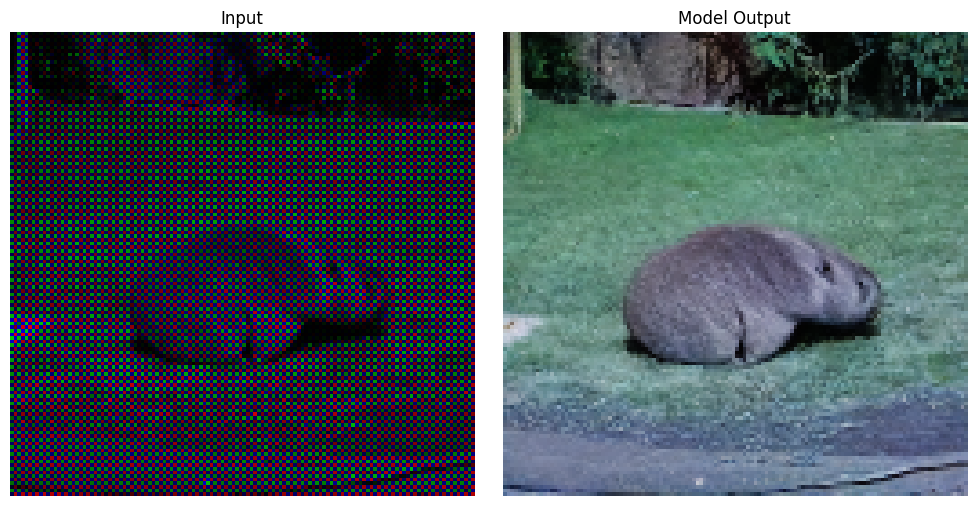

In [19]:
import matplotlib.pyplot as plt

test_file = "/kaggle/input/restore-image/test/test/filtered_images/0.png"
image = cv2.imread(str(test_file))
input_tensor = preprocess(image).unsqueeze(0).to(device)  # shape: [1, 3, 128, 128]
with torch.no_grad():
    output = model(input_tensor)  # shape: [1, 3, 128, 128]
    output = output.squeeze(0).cpu().numpy()  # shape: [3, 128, 128]

output = (np.clip(output * 255.0, 0, 255)).astype(np.uint8)
output = np.transpose(output, (1, 2, 0))  # to HWC

# Show original and model output side by side
plt.figure(figsize=(10, 5))

# Original image (BGR to RGB for matplotlib)
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

# Output image
plt.subplot(1, 2, 2)
plt.title("Model Output")
plt.imshow(output)  # already in RGB (HWC, uint8)
plt.axis("off")

plt.tight_layout()
plt.show()
